# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

# Import modules

In [1]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
import time
from datetime import timedelta
import collections
import cv2
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from sklearn.cross_validation import train_test_split

The scikit-learn version is 0.17.1.


---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [2]:
# Load pickled data


# TODO: fill this in based on where you saved the training and testing data
training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train.shape

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (39209, 32, 32, 3)
Number of classes = 43


# Display a sample image from each traffic sign class in the training dataset

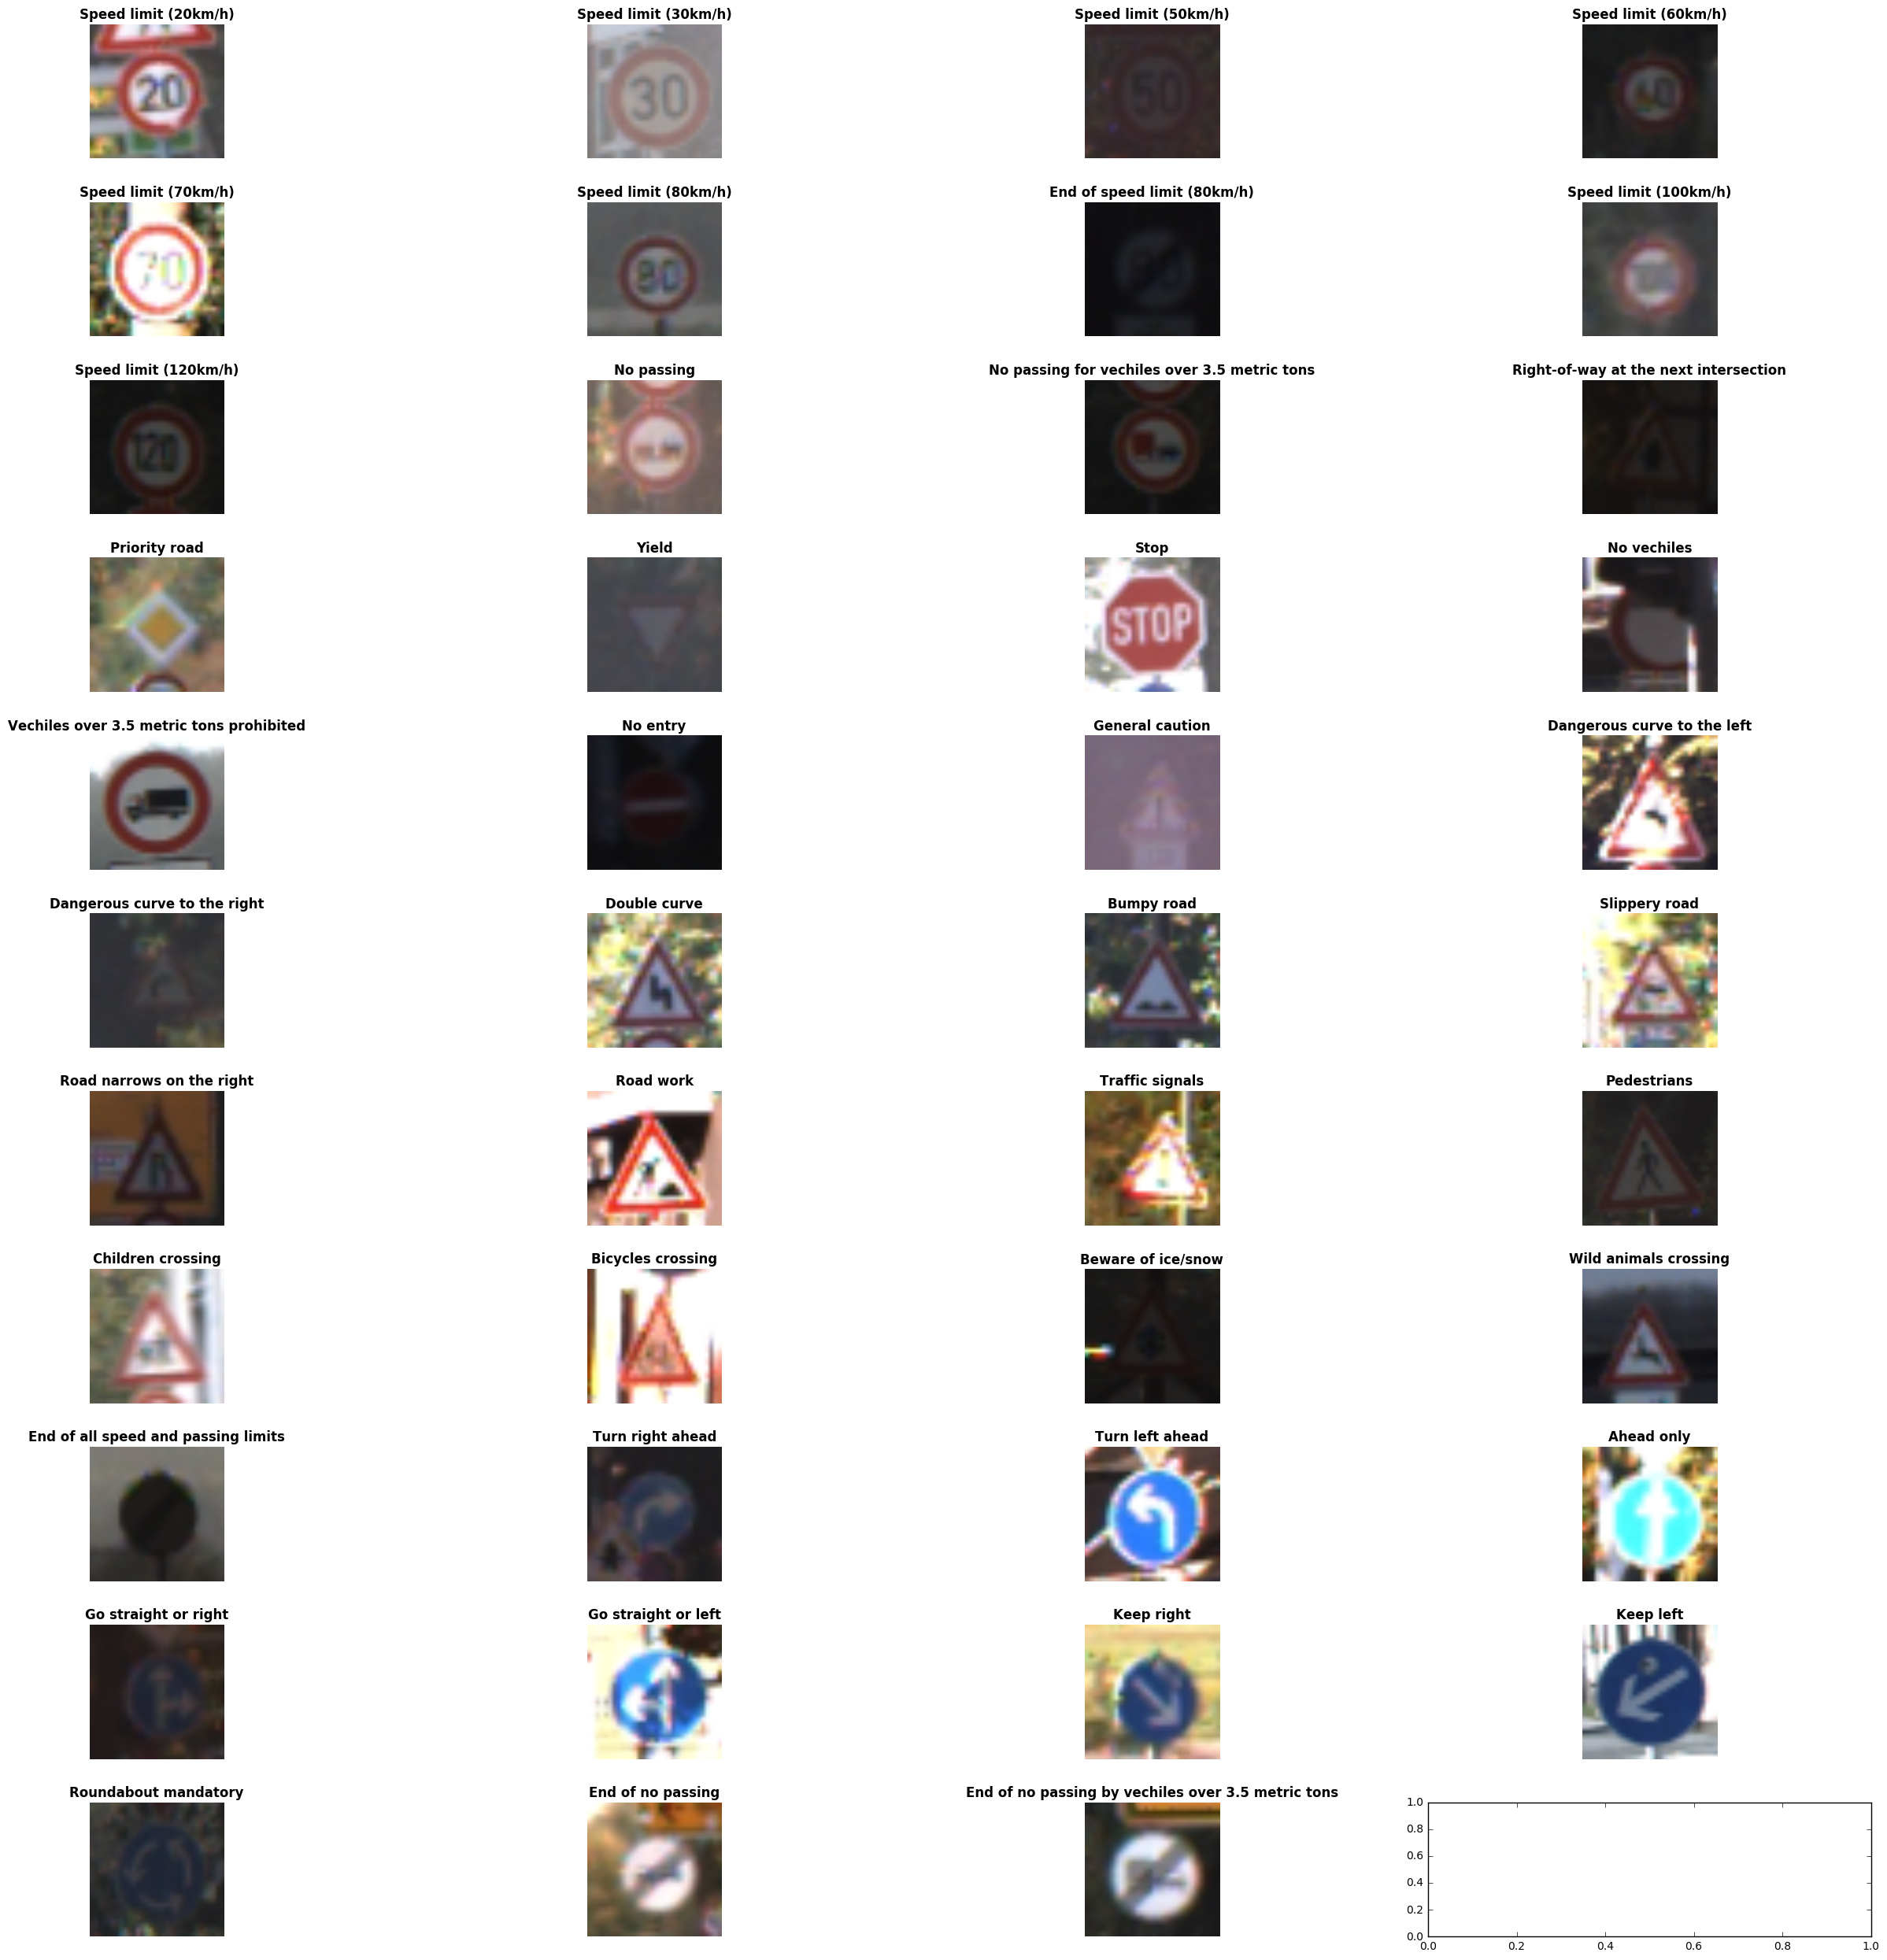

In [4]:
# Read traffic sign class and name information.
sig_names = pd.read_csv('signnames.csv')

_, ax = plt.subplots(11,4,figsize=(25,25))
row_counter = 0
for class_id, sign_name in zip(sig_names.ClassId, sig_names.SignName):
    idx = np.where(y_train == class_id)[0][np.random.randint(0, 10)]
   
    if class_id % 4 == 0 and class_id > 0:
        row_counter += 1
    ax[row_counter, class_id % 4].imshow(X_train[idx])
    ax[row_counter, class_id % 4].set_title(sign_name, fontdict={'fontweight': 'bold'})
    ax[row_counter, class_id % 4].grid(False)
    ax[row_counter, class_id % 4].axis('off')
plt.tight_layout()

# Distribution of traffic sign classes in training data set

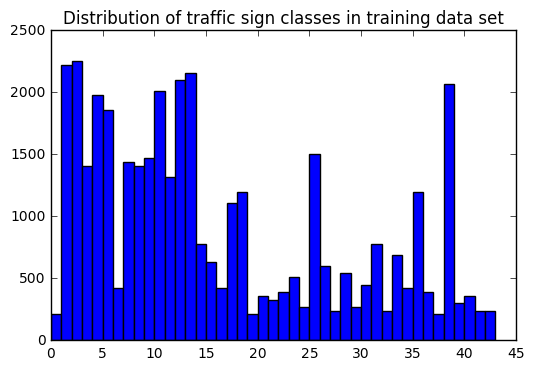

In [5]:
train_count = collections.Counter(train['labels'])
labels, values = zip(*train_count.items())
indexes = np.arange(len(labels))
width = 1
plt.title("Distribution of traffic sign classes in training data set")
plt.bar(indexes, values, width)
plt.show()

# Distribution of traffic sign classes in test data set

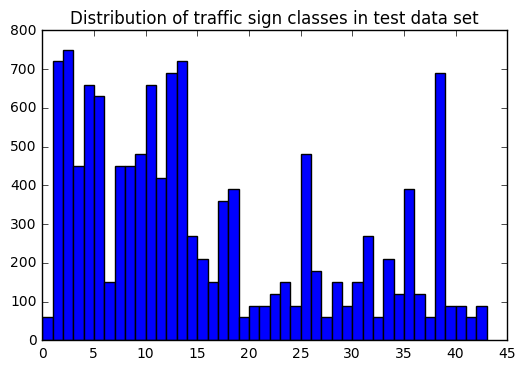

In [6]:
test_count = collections.Counter(test['labels'])
labels, values = zip(*test_count.items())
indexes = np.arange(len(labels))
width = 1
plt.title("Distribution of traffic sign classes in test data set")
plt.bar(indexes, values, width)
plt.show()



# Conclusions based on data exploration

- The classes in the data set are quite imbalanced
- The quality of the images varies very much, but only a  few raffic signs are not recognizable with the human eye.
- The lighting conditions varies much  from bright daylight to darkness, foggy conditions, point of view
- Some traffic signs are partially obscured.
- There are not many training examples for some classes
- All images are taken from 30 frame video sequences of a camera.

We have to deal with imbalanced data, uneven lighting conditions and variation of image quality. 


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

# Data Preprocessing

In [7]:

plt.rcParams.update({'font.size': 18})



### Question 1 

Describe the techniques used to preprocess the data.



**Answer:**

Many images have little contrast. Global contrast optimization will not work well for images which are very bright or very dark.  Working with black and white images provided better results in the benchmark paper "Traffic Sign Recognition with Multi-Scale Convolutional Networks", http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf. 

But I kept the preprocessing to a minimum. The pixel values are converted to floating points between minus -0.5 and 0.5 and nroand the targets are encoded as one-hot vectors. During training, we will jitter ((small, random translations and rotations) the images with Keras's ImageDataGenerator to limit the models ability to memorize examples.

I not converted to grayscale because in my opinion the color of the sign is indicative in some cases

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Merge
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils


# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

X_train_p=np.copy(X_train)
X_test_p=np.copy(X_test)
X_train_p = X_train_p.astype('float32')
X_test_p = X_test_p.astype('float32')
X_train_p /= 255
X_test_p /= 255
#Normalization
X_train_p-=0.5
X_test_p-=0.5
print(X_train_p.shape)
print("Preprocessing done")

Using TensorFlow backend.


(39209, 32, 32, 3)
Preprocessing done


In [9]:

X_tr, X_val, Y_tr, Y_val = train_test_split(X_train_p, Y_train, test_size=0.2, random_state=1)

# jitter images
datagen = ImageDataGenerator(
    rotation_range=3,
    width_shift_range=0.05,
    height_shift_range=0.05)
#datagen.fit(X_tr)

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?

 

**Answer:**
I've selected 20% of the training data to use as a validation set using the train_test-split method of scikit learn. This function shuffels the data randomly before splitting.  No additional data is generated.

In [10]:
from keras.layers.normalization import BatchNormalization
model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same',
                        input_shape=X_tr.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.6))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.6))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My neural network is a feedforward convolutional neural network. Using [1] as a guide, I use a quite simple architecture:

CONV --> RELU --> CONV -->  Batch Normalization-->RELU --> POOL --> CONV-->  Batch   Normalization-->RELU --> CONV -->  Batch Normalization-->RELU --> POOL 
Two densely connected sections, to an internal representation of dimension 512 and to the number of classes (43).
Dropout is used in the dense layers

 The main point is the batch normalization, see [2] for details. Because I spend a week trying batch normalization using tensorflow without success working on my Capstone Nanodegree project I m using Keras here, because batch normalization works out of the box with Keras without any problems (and because I want learn Keras too)
 
 
[1] http://cs231n.github.io/convolutional-networks/

[2] Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift: http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf

In [11]:
from keras.callbacks import ModelCheckpoint

model.fit_generator(generator=datagen.flow(X_tr, Y_tr, batch_size=64),
          samples_per_epoch=X_tr.shape[0],
          nb_epoch=160,
          validation_data=(X_val, Y_val),
          callbacks=[ModelCheckpoint('cnn_model.h5',save_best_only=True)])
model.load_weights("cnn_model.h5")
score = model.evaluate(X_test_p, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

# due to  random jitter on the date, different runs gives slightly different test accuracy results between 0.991 and 0.993 
# one run achieves a very good test result:
# Test score: 0.0340486795809
# Test accuracy: 0.99311163903
# I renamed the saved model to cnn_model_993.h5 to be able to use it later on

Epoch 1/160
31367/31367 [==============================] - 23s - loss: 2.8000 - acc: 0.2459 - val_loss: 1.3844 - val_acc: 0.5807
Epoch 2/160
31367/31367 [==============================] - 22s - loss: 0.9598 - acc: 0.6811 - val_loss: 0.2516 - val_acc: 0.9304
Epoch 3/160
31367/31367 [==============================] - 21s - loss: 0.4672 - acc: 0.8475 - val_loss: 0.1121 - val_acc: 0.9667
Epoch 4/160
31367/31367 [==============================] - 20s - loss: 0.2920 - acc: 0.9079 - val_loss: 0.0635 - val_acc: 0.9827
Epoch 5/160
31367/31367 [==============================] - 22s - loss: 0.2068 - acc: 0.9349 - val_loss: 0.0242 - val_acc: 0.9950
Epoch 6/160
31367/31367 [==============================] - 22s - loss: 0.1623 - acc: 0.9501 - val_loss: 0.0538 - val_acc: 0.9823
Epoch 7/160
31367/31367 [==============================] - 20s - loss: 0.1367 - acc: 0.9586 - val_loss: 0.0188 - val_acc: 0.9964
Epoch 8/160
31367/31367 [==============================] - 20s - loss: 0.1139 - acc: 0.9643 - val

In [16]:
# load the best model 
model.load_weights("cnn_model_993.h5")
score = model.evaluate(X_test_p, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.0340486795809
Test accuracy: 0.99311163903


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**


Answer: My network was trained with the Adam [2] optimizer, a batch size of 64, over 160 epochs. Based on my experience with the machine learning capstone, other optimizers requires a lot of trial and error for the learning rate and other parameters to achieve a good learning (especially on deep networks). Adam works in most cases out of the box quite well in my experience.

[2] https://arxiv.org/abs/1412.6980


### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:** 

I studied the MNIST and CIFAR Tensorflow examples and then I used the IPython Keras example from the Self Driving Course as starting point.  I experimented a while with it and I added some layers and batch normalization as well and got 99,85% test accuracy by applying the jittering on the images too. Then I try to make the live for the CNN harder in order to achieve better test accuracy results.  I increased the drop out rate to 60% and increased the jittering a bit. I observed that I was able to get test accuracy results between 99,1 and 99,3%. It varies a bit with every run due to the stochastic process of jittering. Best result I got was 99,3% and I saved the model apart to reuse it.  It seems that I have beaten the baseline without much preprocessing.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [49]:
def plot_images(images, cls_true, cls_pred=None):
  #  assert len(images) == len(cls_true) == 9
    
    n_imgs=len(images)
    _, ax = plt.subplots(1,n_imgs,figsize=(15,15))
    for i in range(0,n_imgs):
        # Plot image.
        idx=i%n_imgs
     
        ax[idx].imshow(images[i])
     #   ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

      
        ax[idx].set_xlabel(xlabel)
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
   
  #  plt.show()

['33add.jpg', '17add.jpg', '15add.jpg', '13add.jpg', '25add.jpg']


[33, 17, 15, 13, 25]

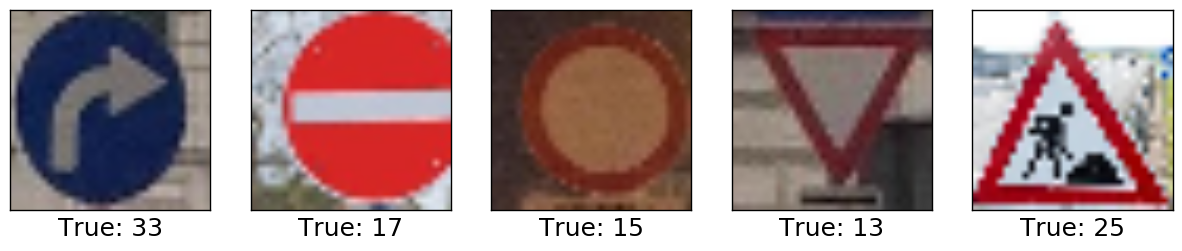

In [62]:
import glob
import cv2

add_images = glob.glob('*add.jpg')
print(add_images)
n_imgs = len(add_images)

shape=(n_imgs,32,32,3);
X_add = np.zeros(shape,dtype='uint8')


def resize_image(image):
    n=min(image.shape[:2])
    crop = cv2.resize(image[:n,:n],(32,32), interpolation = cv2.INTER_CUBIC)    
    return crop

# true class vector
y_add = [int(y[:2]) for y in add_images]

# generate the addition data set from the images 
for img_name in add_images:
    i = add_images.index(img_name)
    img = plt.imread(img_name)
    img = resize_image(img)    
    X_add[i]=img

plot_images(X_add, cls_true = y_add)



### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**
 Number 17 ist slightly cropped at the right, number 15 has low contrast. Maybet this makes classification at bit difficult. Generally I would expect difficulties if the image is to dark or the contrast is very low or if the traffic sign is somewhat rotated or due jitterings.

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.11197541e-34,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   2.49407961e-33,   0.00000000e+00,
         2.83616700e-38,   1.97895156e-31,   0.00000000e+00,
         1.67262010e-33,   9.94198915e-32,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   2.98536773e-38,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.00000000e+00,   1.56488549e-27,   1.11001318e-19,
         3.24813516e-31,   1.18457193e-35,   0.00000000e+00,
         7.24301988e-29,   1.18823235e-29,   0.00000000e+00,
         2.17744629e-37], dtype=float32)

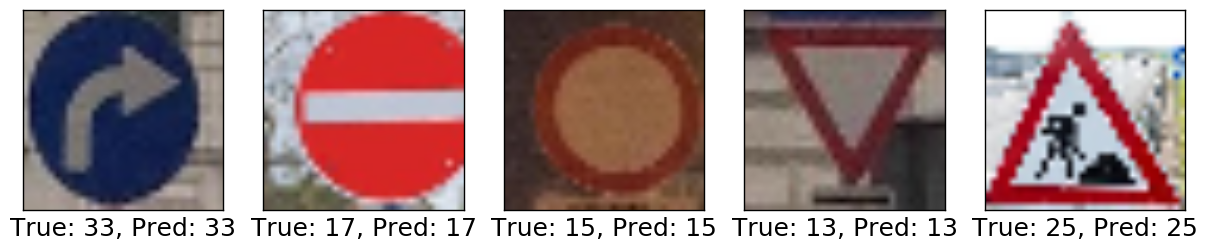

In [67]:
Y_add_p = np_utils.to_categorical(y_add, n_classes)
X_add_p=np.copy(X_add)
X_add_p = X_add_p.astype('float32')
X_add_p /= 255
#Normalization
X_add_p-=0.5

preds = model.predict(X_add_p)
predictions=(list(map(np.argmax, preds)), preds)

plot_images(X_add, cls_true = y_add,cls_pred=predictions[0])


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset?_


**Answer:**
All pictures are classified correctly. This means the prediction accuracy is 100%. The testing accuracy of the model with the test data set was 99,3%. what is only a quite small difference. However 5 signs are not a valid real world test set for testing the model. Furthermore the images where manually located on the images and then cropped. For a real world application we have to implement a neural network that not only classify the signs but locate them on the images taken. Furthermore at least in Germany it is not uncommon to have more than one traffic sign at the same location which are all relevant. Therefore we have to locate all traffic signs and classify them in a real world application

In [73]:
y_add

[33, 17, 15, 13, 25]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff5dc230ba8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7ff5d4784898>], dtype=object)

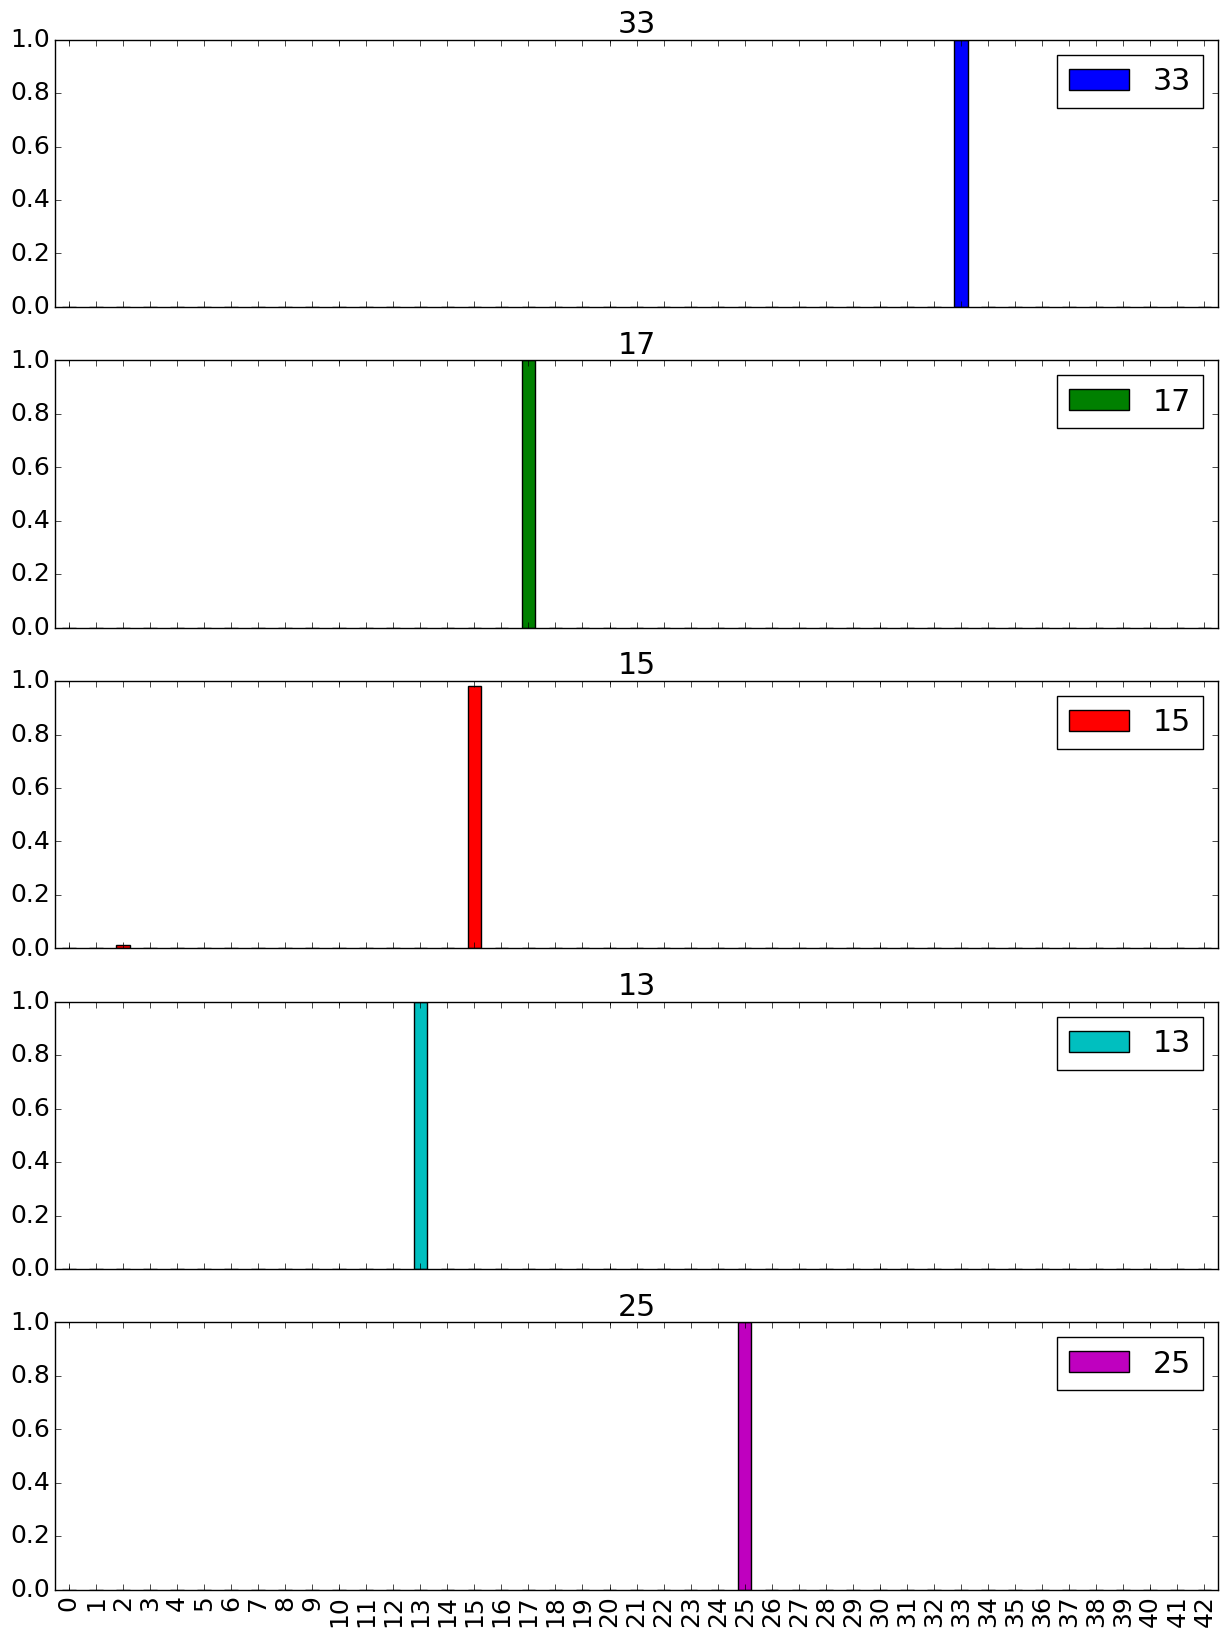

In [80]:
df=pd.DataFrame(predictions[1].T,columns=y_add)
df.plot.bar(subplots=True,figsize=(15,20))

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**
The model is very very certain for the signs 33,17,13 and 25. Only for the sign 15 it is not absolute certain, there is a very small propability for sign 3 too. This is interesting, because the only difference between the both signs is, that sign 3 has a additional number for the maximum speed inside. 

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**
I took screenshots, crop them to the signs,  resized the images, and converted the pixel values to the [-0.5,0.5]-scale used by the model. No other preprocessing

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.